In [36]:
import netCDF4
from osgeo import gdal
from osgeo import osr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import os
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
# Helperfunction to calculate the number of days from the origin (1900-1-1 00:00:00)
def get_days(year, month, day, hour, minute = 0, second = 0, origin = datetime(1900, 1, 1, 0, 0, 0)):
    diff = datetime(year, month, day, hour, minute, second)-origin
    days = diff.days + (diff.seconds/24/3600)
    return(days)

In [2]:
models = ["SMHI-RCA", "MPICSC-REMO1", "DMI-HIRHAM"]
variants = ["RCP85", "RCP45", "RCP26"]
variables = ["tas", "tasmax"]

models_dict = {model: {variant: {variable: glob.glob("../data/prognosedaten/"+variable+"_"+"*"+model+"*"+variant+"*"+".nc") for variable in variables} for variant in variants} for model in models}


for model_name in models_dict.keys():
    for variant_name in models_dict[model_name]:
        for variable_name in models_dict[model_name][variant_name]:
            file = models_dict[model_name][variant_name][variable_name]
            print(model_name+" "+variant_name+" " + variable_name+":"+file[0])


SMHI-RCA RCP85 tas:../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc
SMHI-RCA RCP85 tasmax:../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc
SMHI-RCA RCP45 tas:../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP45_QM_1981-2099_10-229_2-102_mask.nc
SMHI-RCA RCP45 tasmax:../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP45_QM_1981-2099_10-229_2-102_mask.nc
SMHI-RCA RCP26 tas:../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP26_QM_1981-2099_10-229_2-102_mask.nc
SMHI-RCA RCP26 tasmax:../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP26_QM_1981-2099_10-229_2-102_mask.nc
MPICSC-REMO1 RCP85 tas:../data/prognosedaten/tas_MPICSC-REMO1-MPIESM-EUR11-RCP85_QM_1981-2099_10-229_2-102_mask.nc
MPICSC-REMO1 RCP85 tasmax:../data/prognosedaten/tasmax_MPICSC-REMO1-MPIESM-EUR11-RCP85_QM_1981-2099_10-229_2-102_mask.nc
MPICSC-REMO1 RCP45 tas:../data/prognosedaten/tas_MPICSC-REMO1-MPIESM-EUR11-RCP45_QM_1981-2099_10-229_2-1

In [3]:
tas_1981_2099 = netCDF4.Dataset("../data/prognosedaten/tas_DMI-HIRHAM-ECEARTH-EUR11-RCP26_QM_1981-2099_10-229_2-102_mask.nc")
tasmax_1981_2099 = netCDF4.Dataset("../data/prognosedaten/tasmax_DMI-HIRHAM-ECEARTH-EUR11-RCP26_QM_1981-2099_10-229_2-102_mask.nc")

In [4]:
# what dimensions does the netCDF file have?
tas_1981_2099.dimensions
tasmax_1981_2099.dimensions

# the shape of lon 220 cells (each 2km) east-west, looks correct
# the shape of lat 101 cells (each 2km) north-south, looks correct
# the shape of time 43'434 days, ~118 days (1981-2099) looks correct

{'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 220,
 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 101,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 43464}

In [5]:
# What variables does the dataset have?
tas_1981_2099.variables.keys()
tasmax_1981_2099.variables.keys()

dict_keys(['lon', 'lat', 'time', 'tasmax'])

In [6]:
# metadata on variable "tas"
tas_1981_2099.variables["tas"]

<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    long_name: daily mean temperature
    units: degrees_C
    _FillValue: -999.0
    missing_value: -999.0
    grid_name: ch02.lonlat
    version: v1.2
    prod_date: 2013-08-30 10:47:37
    method: Bias-corrected and downscaled by QM
unlimited dimensions: time
current shape = (43464, 101, 220)
filling on

In [7]:
tasmax_1981_2099.variables["tasmax"]

<class 'netCDF4._netCDF4.Variable'>
float32 tasmax(time, lat, lon)
    long_name: daily maximum temperature
    units: degrees_C
    _FillValue: -999.0
    missing_value: -999.0
    grid_name: ch02.lonlat
    version: v1.2
    prod_date: 2013-08-30 10:47:37
    method: Bias-corrected and downscaled by QM
unlimited dimensions: time
current shape = (43464, 101, 220)
filling on

In [8]:
# metadata on variable "time"
tas_1981_2099.variables["time"]

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 1900-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (43464,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [9]:
tasmax_1981_2099.variables["time"]

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 1900-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (43464,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [10]:
# values are floating point (!) values (since it's always 12 noon instead of midnight)
# the values start at 29'585.5 and end on 73'048.5
times = tas_1981_2099.variables["time"][:]

times

masked_array(data=[29585.5, 29586.5, 29587.5, ..., 73046.5, 73047.5,
                   73048.5],
             mask=False,
       fill_value=1e+20)

In [11]:
times2 = tasmax_1981_2099.variables["time"][:]

# The length of variable time is same for both datasets (43464)
len(times2) == len(times)

# however, the values are not. In 43'095 of 43'464 cases (the values do not match up)
comp_times = pd.DataFrame({"times":times, "times2":times2, "unequal": times != times2})
sum(comp_times["unequal"])

# apparently, the values of "tasmax_1981_2099" is "0" in these cases
# I will assume that this is an issue of "tasmax_1981_2099", and that the dates do in fact correspond to each other
comp_times[comp_times["unequal"]]



,times,times2,unequal


In [12]:
# lat, lon are indeed in WGS84
lats = tas_1981_2099.variables["lat"][:]
lons = tas_1981_2099.variables["lon"][:]
lats

masked_array(data=[45.77083333, 45.79166667, 45.8125    , 45.83333333,
                   45.85416667, 45.875     , 45.89583333, 45.91666667,
                   45.9375    , 45.95833333, 45.97916667, 46.        ,
                   46.02083333, 46.04166667, 46.0625    , 46.08333333,
                   46.10416667, 46.125     , 46.14583333, 46.16666667,
                   46.1875    , 46.20833333, 46.22916667, 46.25      ,
                   46.27083333, 46.29166667, 46.3125    , 46.33333333,
                   46.35416667, 46.375     , 46.39583333, 46.41666667,
                   46.4375    , 46.45833333, 46.47916667, 46.5       ,
                   46.52083333, 46.54166667, 46.5625    , 46.58333333,
                   46.60416667, 46.625     , 46.64583333, 46.66666667,
                   46.6875    , 46.70833333, 46.72916667, 46.75      ,
                   46.77083333, 46.79166667, 46.8125    , 46.83333333,
                   46.85416667, 46.875     , 46.89583333, 46.91666667,
      

In [13]:
# At least spatially, the datasets match up exatly
all(tas_1981_2099.variables["lat"][:] == tasmax_1981_2099.variables["lat"][:])
all(tas_1981_2099.variables["lon"][:] == tasmax_1981_2099.variables["lon"][:])

True

In [14]:
# I can extract the first day of the dataset *by the position* like so
tas_0 = tas_1981_2099.variables["tas"][0,]
tas_0

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-999.0,
  dtype=float32)

In [15]:
# to get the position when provided a date, I need to do this:
# (using the helperfunction to get the number of days since 1900-01-01 00:00:00)

np.argmin(np.abs(times - get_days(2030, 4, 1, 12)))

# see https://stackoverflow.com/a/29136166/4139249

17987

In [16]:
# lets wrap this in a function

def index_from_value(values, value):
    return np.argmin(np.abs(values-value))

day_idx = get_days(2030,4,1,12)
index_from_value(times, day_idx)
index_from_value(lons, 7.810031)





90

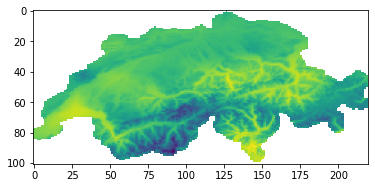

In [17]:
# I can plot this raster using numpy's pyplot
# but the y axis needs to be flipped
# plt.imshow(tas_0)
plt.imshow(np.flip(tas_0, 0))

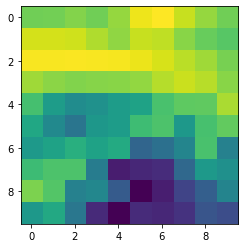

In [18]:
# You can subset a specific area by passing ranges in [ ]
plt.imshow(np.flip(tas_1981_2099.variables["tas"][2,40:50,100:110], 0))

In [19]:
tas_1981_2099["/tas/"]

<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    long_name: daily mean temperature
    units: degrees_C
    _FillValue: -999.0
    missing_value: -999.0
    grid_name: ch02.lonlat
    version: v1.2
    prod_date: 2013-08-30 10:47:37
    method: Bias-corrected and downscaled by QM
unlimited dimensions: time
current shape = (43464, 101, 220)
filling on


What I need to calculate is the following (pseudocode):

```
for years in 2031-2040:
    for days in 30.09.year-01.04.(year+1):
        ((tas-10)+(tas_max-10))/2*1.045
        
```

Variable `time` is in the `units`: `number of days since 1900-1-1 00:00:00`


In [20]:
times_dict = {x:[get_days(x, 9, 30, 12), get_days(x+1, 4,1,12)] for x in range(2031, 2041)}


    


In [21]:
# Import the kanton of luzern ....
kantonsgrenze = gpd.read_file("../data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/", layer = "TLM_KANTONSGEBIET").query("NAME == 'Luzern'") # fiona.listlayers("data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/")

# buffer it with 2km, transform it to wsg84 and get the bounding box
kanton_bounds = kantonsgrenze.buffer(2000).to_crs(4326).bounds
kanton_bounds

,minx,miny,maxx,maxy
8,7.810031,46.757013,8.540349,47.30518


In [22]:
# boundary_dict = {"lat":[7.810031, 8.540349], "lon":[46.757013,47.30518]}
lon = [7.810031, 8.540349]
lat = [46.757013,47.30518]

lon = [kanton_bounds["minx"].iloc[0], kanton_bounds["maxx"].iloc[0]]
lat = [kanton_bounds["miny"].iloc[0], kanton_bounds["maxy"].iloc[0]]


lon

[7.810030844025151, 8.540348762846177]

In [24]:
lon_idx = [index_from_value(lons, x) for x in lon]
lat_idx = [index_from_value(lats, x) for x in lat]


for model_name in models_dict.keys():
    for variant_name in models_dict[model_name]:
        tas_filename = models_dict[model_name][variant_name]["tas"][0]       # unsafe if there are multiple matches 
        tasmax_filename = models_dict[model_name][variant_name]["tasmax"][0] # same goes for this line
        print(model_name+" "+variant_name+" " + variable_name+":"+tas_filename)
        
        tas = netCDF4.Dataset(tas_filename)
        tasmax = netCDF4.Dataset(tasmax_filename)
        
        all_years = []
        for year, date_idxs in times_dict.items():
            start_date_idx = index_from_value(times, date_idxs[0])
            end_date_idx = index_from_value(times, date_idxs[1])
            print(year, ":",start_date_idx, "to", end_date_idx)
            subset_mean = tas.variables["tas"][start_date_idx:end_date_idx,lat_idx[0]:lat_idx[1],lon_idx[0]:lon_idx[1]]
            subset_max = tasmax.variables["tasmax"][start_date_idx:end_date_idx,lat_idx[0]:lat_idx[1],lon_idx[0]:lon_idx[1]]

            # the magic happens here:
            res = np.sum(((subset_mean-10)+(subset_max-10))/2*1.045,axis = 0)
            all_years.append(res)

            xmin,ymin,xmax,ymax = lon[0], lat[0], lon[1], lat[1]

            nrows,ncols = np.shape(res)

            xres = (xmax-xmin)/float(ncols)
            yres = (ymax-ymin)/float(nrows)
            geotransform=(xmin, xres, 0,ymax, 0, -yres) 
            subdir = "../output/"+model_name+"/"+variant_name+"/"
            os.makedirs(subdir, exist_ok=True)
            
            
#             output_raster = gdal.GetDriverByName("GTiff").Create(subdir+str(year)+".tif", res.shape[1], res.shape[0], 1, gdal.GDT_Float32)
#             output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
#             srs = osr.SpatialReference()                 # Establish its coordinate encoding
#             srs.ImportFromEPSG(4326)   
#             output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#             output_raster.GetRasterBand(1).WriteArray(res)   # Writes my array to the raster
#             output_raster.FlushCache()

#             del output_raster
            
#         all_years_np = np.stack(all_years)
#         all_years_mean = np.mean(all_years_np, axis = 0)
        
#         output_raster = gdal.GetDriverByName("GTiff").Create(subdir+"Mean.tif", res.shape[1], res.shape[0], 1, gdal.GDT_Float32)
#         output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
#         srs = osr.SpatialReference()                 # Establish its coordinate encoding
#         srs.ImportFromEPSG(4326)   
#         output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#         output_raster.GetRasterBand(1).WriteArray(all_years_mean)   # Writes my array to the raster
#         output_raster.FlushCache()
        
#         del output_raster
        

SMHI-RCA RCP85 tasmax:../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc
2031 : 18534 to 18718
2032 : 18900 to 19083
2033 : 19265 to 19448
2034 : 19630 to 19813
2035 : 19995 to 20179
2036 : 20361 to 20544
2037 : 20726 to 20909
2038 : 21091 to 21274
2039 : 21456 to 21640
2040 : 21822 to 22005
SMHI-RCA RCP45 tasmax:../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP45_QM_1981-2099_10-229_2-102_mask.nc
2031 : 18534 to 18718
2032 : 18900 to 19083
2033 : 19265 to 19448
2034 : 19630 to 19813
2035 : 19995 to 20179
2036 : 20361 to 20544
2037 : 20726 to 20909
2038 : 21091 to 21274
2039 : 21456 to 21640
2040 : 21822 to 22005
SMHI-RCA RCP26 tasmax:../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP26_QM_1981-2099_10-229_2-102_mask.nc
2031 : 18534 to 18718
2032 : 18900 to 19083
2033 : 19265 to 19448
2034 : 19630 to 19813
2035 : 19995 to 20179
2036 : 20361 to 20544
2037 : 20726 to 20909
2038 : 21091 to 21274
2039 : 21456 to 21640
2040 : 21822 to 22005
MPICSC-REM

In [ ]:
crs = CRS.from_epsg(4326)
transform = from_origin(xmin, ymax, xres, yres)
with rasterio.open(subdir+str(year)+".tif",
                   "w", 
                   driver = "GTiff", 
                   height=res.shape[0], 
                   width = res.shape[1], 
                   count = 1, 
                   dtype = res.dtype,
                   transform = transform,
                   crs = crs, masked = True
                  ) as dst:
        dst.write(res, 1)